# Parameter Identification Technique (PIT) on a nonlinear VMM model

# Purpose
Show the general workflow by applying PIT regression on a very simple model

# Methodology
* Load time series from a ZigZag test
* Determine yaw rate and acceleration (compare with accelerometers from test).
* Find the best parameter values in the Nomoto model using OLS linear regression.

# Setup

In [1]:
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt
#if os.name == 'nt':
#    plt.style.use('presentation.mplstyle')  # Windows

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl
#from src.models import linear_vmm
import src.nonlinear_vmm_equations as eq
from src.symbols import *
import src.symbols as symbols
from src.models import regression

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


## Load test

In [183]:
df_runs = mdl.runs()

In [184]:
#id=22773
#id=22616
#id=22774
id=22770


df, units, meta_data = mdl.load(id=id, dir_path='../data/processed/kalman')
df.index = df.index.total_seconds()
df = df.iloc[1000:-100].copy()
df.index-=df.index[0]
df.sort_index(inplace=True)

In [185]:
meta_data['rho']=1000
meta_data['mass'] = meta_data['Volume']*meta_data['rho']
meta_data.dropna()

A0                                                               0.722775
KXX                                                              0.331311
KZZ                                                              1.253641
TA                                                               0.206311
TF                                                               0.206311
Volume                                                           0.441027
angle1                                                               10.0
angle2                                                               10.0
beam                                                             0.946602
comment                                                        ZZ 10/10PS
date                                                           2020-09-24
facility                                                              MDL
file_path_hdf5          \\sspa.local\lab\MeasuredataMDL\40199079\005\0...
gm                                    

In [186]:
df.head()

,Arr/Ind/Arr,Arr/Ind/Fri,Fan/Aft/Angle,Fan/Aft/AngleOrder,Fan/Aft/Fx,Fan/Aft/FxOrder,Fan/Aft/Rpm,Fan/Aft/RpmOrder,Fan/ForceFactor,Fan/Fore/Angle,Fan/Fore/AngleOrder,Fan/Fore/Fx,Fan/Fore/FxOrder,Fan/Fore/Rpm,Fan/Fore/RpmOrder,Hull/Acc/X1,Hull/Acc/Y1,Hull/Acc/Y2,Hull/Acc/Z1,Hull/Acc/Z2,Hull/Acc/Z3,Prop/PS/Rpm,Prop/PS/Thrust,Prop/PS/Torque,Prop/SB/Rpm,Prop/SB/Thrust,Prop/SB/Torque,delta,Rudder/MaxAngle,Rudder/Rate,Wind/Course,Wind/CourseTreshold,Wind/GWA,lab/WaveHeight,roll,pitch,psi,x0,y0,z0,x01d_gradient,y01d_gradient,z01d_gradient,z02d_gradient,psi1d_gradient,x0_filtered,x01d,x02d,y0_filtered,y01d,y02d,psi_filtered,psi1d,psi2d,u,v,w,u1d,v1d,w1d,r,r1d,beta
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,0.0,1.0,2.146755,0.030377,-0.005084,0.0,-0.231020,10.131507,1.0,2.146755,-0.804106,-0.015313,0.0,-1.579709,11.329219,0.005152,-0.117922,-0.149800,0.027934,-0.020115,0.306532,9.638443,5.212568,-0.107456,9.569672,5.843590,0.110122,-0.174529,0.645772,14.89,-0.164497,0.1,0.0,0.000025,0.010559,-0.000138,-0.219475,17.028510,-0.410672,0.002577,0.906078,-0.146491,-0.000364,-0.012857,3.489974e-05,17.028036,0.911363,-0.004745,-0.410684,-0.161218,-0.022346,-0.219435,0.002391,0.013812,0.924602,0.041031,-0.000364,0.000233,-0.022843,-0.012857,0.002391,0.013812,-0.044348
0.009981,0.0,1.0,2.146755,0.030403,-0.021057,0.0,-0.057346,10.131507,1.0,2.146755,-0.804815,-0.014856,0.0,-10.533567,11.329219,0.010956,-0.096004,-0.143346,0.022136,0.005674,-0.000222,9.615496,5.230893,-0.111292,9.550952,5.783433,0.108994,-0.174529,0.645772,14.89,-0.164642,0.1,0.0,0.000025,0.010398,0.000142,-0.219388,17.038460,-0.412630,0.002645,0.505632,-0.101819,0.000060,0.018107,4.376005e-03,17.036705,0.909972,-0.004745,-0.412286,-0.161136,-0.022234,-0.219398,0.002622,0.013777,0.923229,0.040774,0.000060,0.000208,-0.022733,0.018107,0.002622,0.013777,-0.044136
0.019982,0.0,1.0,2.146755,0.030438,-0.032809,0.0,0.077734,10.131507,1.0,2.146755,-0.805733,-0.015695,0.0,3.456837,11.329219,-0.005810,-0.088268,-0.153671,0.044684,-0.000773,-0.005377,9.626140,5.297672,-0.113674,9.553160,5.757171,0.109549,-0.174529,0.645772,14.89,-0.164830,0.1,0.0,0.000025,0.010216,-0.000132,-0.219388,17.038594,-0.412703,0.002578,0.928673,-0.151704,-0.000003,0.012563,4.360924e-03,17.042829,0.910426,-0.005232,-0.413387,-0.161410,-0.022011,-0.219372,0.002846,0.013738,0.923733,0.040582,-0.000003,-0.000316,-0.022622,0.012563,0.002846,0.013738,-0.043905
0.029986,0.0,1.0,2.146755,0.030482,-0.034330,0.0,0.000545,10.131507,1.0,2.146755,-0.806883,-0.015386,0.0,3.707699,11.329219,-0.014192,-0.097293,-0.142701,0.011185,0.000516,-0.009244,9.591443,5.393104,-0.113956,9.551628,5.782021,0.111520,-0.174529,0.645772,14.89,-0.165065,0.1,0.0,0.000025,0.010032,0.000143,-0.219301,17.057043,-0.415665,0.002645,1.328437,-0.251442,0.000312,0.003802,4.361360e-03,17.055091,0.910740,-0.004561,-0.415491,-0.161690,-0.022007,-0.219322,0.003056,0.013704,0.924102,0.040330,0.000312,0.000336,-0.022472,0.003802,0.003056,0.013704,-0.043615
0.039989,0.0,1.0,2.146755,0.030525,-0.024895,0.0,0.019842,10.131507,1.0,2.146755,-0.808023,-0.014413,0.0,0.465785,11.329219,-0.007744,-0.105673,-0.159479,0.054347,0.003740,-0.008600,9.537870,5.507932,-0.112194,9.571466,5.856332,0.114178,-0.174529,0.645772,14.89,-0.165299,0.1,0.0,0.000025,0.009867,-0.000105,-0.219301,17.065173,-0.417734,0.002585,0.878597,-0.154635,0.000073,-0.002022,-1.776357e-15,17.064518,0.909235,-0.004410,-0.417342,-0.161486,-0.021952,-0.219300,0.003258,0.013662,0.922590,0.040182,0.000073,0.000472,-0.022386,-0.002022,0.003258,0.013662,-0.043526


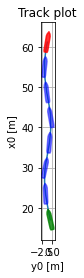

In [187]:
from src.visualization.plot import track_plot
fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
track_plot(df=df, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);

## Yaw rate

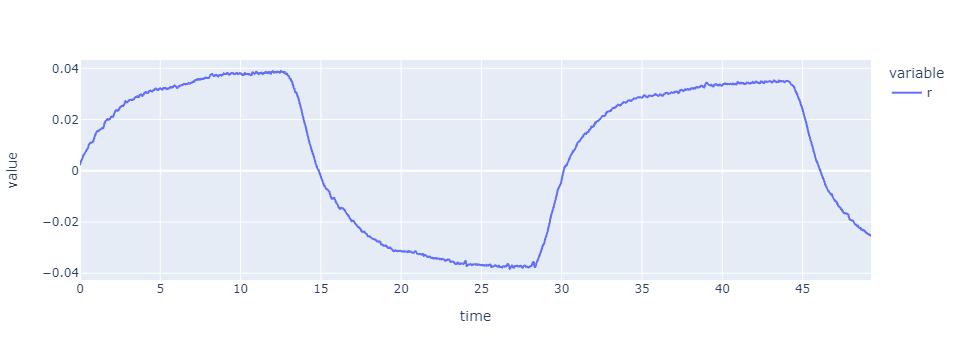

In [188]:
px.line(data_frame=df, y=['r'], width=1400, height=300,)

# Nonlinear VMM

## N

In [189]:
Math(vlatex(eq.N_eq))

<IPython.core.display.Math object>

In [190]:
N_eq = eq.N_eq.copy()
N_eq = N_eq.subs([
    (x_G,0),  # Assuming or moving to CG=0
    #(I_z,1),  # Removing inertia
    #(eq.p.Nrdot,0),  # Removing added mass
    #(eq.p.Nvdot,0),  # Removing added mass
    #(eq.p.Nudot,0),  # Removing added mass
    
])  

solution = sp.solve(N_eq,r.diff())[0]
N_eq = sp.Eq(r.diff(), solution*(I_z-eq.p.Nrdot))  # Putting r1d on the LHS

In [191]:
#Math(vlatex(N_eq))

In [192]:
diff_eq_N = regression.DiffEqToMatrix(ode=N_eq, label=r.diff(), base_features=[delta,u,v,r])

In [193]:
Math(vlatex(diff_eq_N.acceleration_equation))

<IPython.core.display.Math object>

$ y = X \cdot \beta + \epsilon $

In [194]:
Math(vlatex(diff_eq_N.acceleration_equation_x))

<IPython.core.display.Math object>

In [195]:
Math(vlatex(diff_eq_N.eq_y))

<IPython.core.display.Math object>

In [196]:
diff_eq_N.eq_beta

Eq(beta, Matrix([
[N_{deltadeltadelta}],
[            N_{rrr}],
[             N_{uu}],
[            N_{vvv}],
[    N_{rdeltadelta}],
[    N_{vdeltadelta}],
[        N_{rrdelta}],
[            N_{vrr}],
[        N_{uudelta}],
[            N_{uur}],
[            N_{uuv}],
[        N_{vvdelta}],
[            N_{vvr}],
[         N_{udelta}],
[             N_{ur}],
[             N_{uv}],
[        N_{vrdelta}],
[        N_{\dot{v}}],
[          N_{delta}],
[              N_{r}],
[              N_{v}]]))

In [197]:
Math(vlatex(diff_eq_N.eq_X))

<IPython.core.display.Math object>

In [198]:
diff_eq_N.X_lambda

<function _lambdifygenerated(delta, r, u, v, v1d)>

In [199]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
def show_pred(X,y,results, label):
    
    display(results.summary())
    
    X_ = X
    y_ = y
    y_pred = results.predict(X_)
    
    prstd, iv_l, iv_u = wls_prediction_std(results, exog=X_, alpha=0.05)
    #iv_l*=-1 
    #iv_u*=-1
    
    fig,ax=plt.subplots()
    ax.plot(X_.index,y_, label='Numerical gradient from model test')
    ax.plot(X_.index,y_pred, '--', label='OLS')
    ax.set_ylabel(label)
    
    ax.fill_between(X_.index, y1=iv_l, y2=iv_u, zorder=-10, color='grey', alpha=0.5, label=r'5\% confidence')
    ax.legend();

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    r1d   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          3.972e+04
Date:                Wed, 07 Jul 2021   Prob (F-statistic):                        0.00
Time:                        14:36:45   Log-Likelihood:                          30319.
No. Observations:                4927   AIC:                                 -6.060e+04
Df Residuals:                    4906   BIC:                                 -6.046e+04
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Ndeltadeltadelta    -0.4535      0.125     -3.638      0.000      -0.698      -0.209
Nrrr              1440.4848    135.396     10.639      0.000    1175.048    1705.922
Nuu               3.174e-05   1.67e-05      1.899      0.058   -1.03e-06    6.45e-05
Nvvv                54.2282      2.288     23.706      0.000      49.744      58.713
Nrdeltadelta        18.8085      3.691      5.096      0.000      11.572      26.044
Nvdeltadelta         6.0573      0.966      6.273      0.000       4.164       7.950
Nrrdelta           322.2483     38.154      8.446      0.000     247.449     397.047
Nvrr              1362.4609    101.690     13.398      0.000    1163.103    1561.818
Nuudelta           -21.5064      1.411    -15.238      0.000     -24.273     -18.739
Nuur              -172.2160     13.540    -12.719      0.000    -198.761    -145.671
Nuuv               -13.8342      2.985     -4.634      0.000     -19.686      -7.982
Nvvdelta            34.4252      2.452     14.039      0.000      29.618      39.232
Nvvr               453.9974     25.983     17.473      0.000     403.060     504.935
Nudelta             38.8798      2.540     15.304      0.000      33.899      43.860
Nur                311.6477     24.420     12.762      0.000     263.773     359.523
Nuv                 25.0467      5.388      4.649      0.000      14.484      35.610
Nvrdelta           215.7826     19.550     11.037      0.000     177.456     254.109
Nvdot               -0.8628      0.012    -74.228      0.000      -0.886      -0.840
Ndelta             -17.5344      1.141    -15.373      0.000     -19.770     -15.298
Nr                -140.6724     10.990    -12.800      0.000    -162.218    -119.127
Nv                 -11.4465      2.429     -4.713      0.000     -16.208      -6.685
==============================================================================
Omnibus:                      387.191   Durbin-Watson:                   0.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1261.964
Skew:                           0.379   Prob(JB):                    9.29e-275
Kurtosis:                       5.361   Cond. No.                     1.95e+07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 8.6e-12. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

None

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    r1d   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          4.378e+04
Date:                Wed, 07 Jul 2021   Prob (F-statistic):                        0.00
Time:                        14:36:45   Log-Likelihood:                          30311.
No. Observations:                4927   AIC:                                 -6.058e+04
Df Residuals:                    4908   BIC:                                 -6.046e+04
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Nrrr          1798.7939     82.036     21.927      0.000    1637.966    1959.621
Nvvv            59.0259      1.614     36.573      0.000      55.862      62.190
Nrdeltadelta    31.6005      1.042     30.319      0.000      29.557      33.644
Nvdeltadelta     9.3491      0.327     28.557      0.000       8.707       9.991
Nrrdelta       433.0430     21.214     20.413      0.000     391.454     474.633
Nvrr          1631.3180     61.817     26.389      0.000    1510.129    1752.507
Nuudelta       -21.0073      1.405    -14.952      0.000     -23.762     -18.253
Nuur          -167.1640     13.396    -12.479      0.000    -193.426    -140.902
Nuuv           -12.9458      2.959     -4.375      0.000     -18.747      -7.144
Nvvdelta        41.2780      1.502     27.489      0.000      38.334      44.222
Nvvr           518.2626     16.829     30.796      0.000     485.271     551.254
Nudelta         37.9956      2.529     15.024      0.000      33.038      42.954
Nur            302.6449     24.155     12.529      0.000     255.291     349.999
Nuv             23.4398      5.338      4.391      0.000      12.975      33.904
Nvrdelta       271.2891     11.464     23.664      0.000     248.814     293.764
Nvdot           -0.8638      0.011    -76.283      0.000      -0.886      -0.842
Ndelta         -17.1476      1.136    -15.101      0.000     -19.374     -14.921
Nr            -136.7277     10.869    -12.580      0.000    -158.035    -115.420
Nv             -10.7392      2.405     -4.466      0.000     -15.453      -6.025
==============================================================================
Omnibus:                      446.277   Durbin-Watson:                   0.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1510.375
Skew:                           0.437   Prob(JB):                         0.00
Kurtosis:                       5.567   Cond. No.                     4.00e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 2.39e-11. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

None

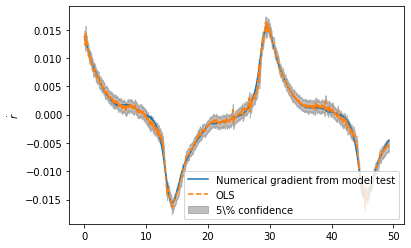

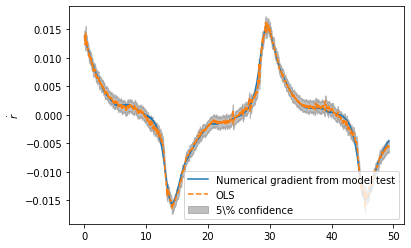

In [221]:
X = diff_eq_N.calculate_features(data=df)
y = diff_eq_N.calculate_label(y=df['r1d'])

model_N = sm.OLS(y,X)
results_N = model_N.fit()

display(show_pred(X=X,y=y,results=results_N, label=r'$\dot{r}$'))

## Remove features with low confidence:
results_summary_N = regression.results_summary_to_dataframe(results_N)
confidence = 0.0001
mask = results_summary_N['$P_{value}$'] < confidence
results_summary_N.loc[mask]

good_columns = results_summary_N.loc[mask].index
X_good=X[good_columns]
model_N = sm.OLS(y,X_good)
results_N = model_N.fit()
display(show_pred(X=X_good,y=y,results=results_N, label=r'$\dot{r}$'))
results_summary_N = regression.results_summary_to_dataframe(results_N)

## Y

In [222]:
Y_eq = eq.Y_eq.copy()
Y_eq = Y_eq.subs([
    #(eq.p.Yvdot,1),  # Removing added mass
    #(eq.p.Yudot,0),  # Removing added mass
    #(eq.p.Yrdot,0),  # Removing added mass  
    (x_G,0),  
    
])  
solution = sp.solve(Y_eq,v.diff())[0]
solution = solution*(m-eq.p.Yvdot)
solution = solution + m*r*u # (adding u*m*r to the measurement fy instead)  
Y_eq = sp.simplify(sp.Eq(v.diff(), solution))  # Putting r1d on the LHS

In [223]:
Math(vlatex(Y_eq))

<IPython.core.display.Math object>

In [224]:
diff_eq_Y = regression.DiffEqToMatrix(ode=Y_eq, label=v.diff(), base_features=[delta,u,v,r])

In [225]:
diff_eq_Y.eq_beta

Eq(beta, Matrix([
[        Y_{rrr}],
[         Y_{uu}],
[        Y_{vvv}],
[Y_{rdeltadelta}],
[Y_{vdeltadelta}],
[    Y_{rrdelta}],
[        Y_{vrr}],
[    Y_{uudelta}],
[        Y_{uur}],
[        Y_{uuv}],
[    Y_{vvdelta}],
[        Y_{vvr}],
[     Y_{udelta}],
[         Y_{ur}],
[         Y_{uv}],
[    Y_{vrdelta}],
[    Y_{\dot{r}}],
[      Y_{delta}],
[          Y_{r}],
[          Y_{v}]]))

In [226]:
diff_eq_Y.acceleration_equation_x

Eq(y, Y_{\dot{r}}*x_17 + Y_{delta}*x_18 + Y_{rdeltadelta}*x_4 + Y_{rrdelta}*x_6 + Y_{rrr}*x_1 + Y_{r}*x_19 + Y_{udelta}*x_13 + Y_{ur}*x_14 + Y_{uudelta}*x_8 + Y_{uur}*x_9 + Y_{uuv}*x_10 + Y_{uu}*x_2 + Y_{uv}*x_15 + Y_{vdeltadelta}*x_5 + Y_{vrdelta}*x_16 + Y_{vrr}*x_7 + Y_{vvdelta}*x_11 + Y_{vvr}*x_12 + Y_{vvv}*x_3 + Y_{v}*x_20)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    v1d   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          6.451e+05
Date:                Wed, 07 Jul 2021   Prob (F-statistic):                        0.00
Time:                        14:37:49   Log-Likelihood:                          31138.
No. Observations:                4927   AIC:                                 -6.224e+04
Df Residuals:                    4907   BIC:                                 -6.211e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Yrrr           532.1957     73.701      7.221      0.000     387.709     676.683
Yuu             -0.0001    1.4e-05     -9.205      0.000      -0.000      -0.000
Yvvv            18.4663      1.574     11.736      0.000      15.381      21.551
Yrdeltadelta    25.5547      0.890     28.720      0.000      23.810      27.299
Yvdeltadelta     9.0746      0.270     33.665      0.000       8.546       9.603
Yrrdelta       318.1756     18.252     17.432      0.000     282.394     353.958
Yvrr           696.1517     56.008     12.429      0.000     586.350     805.953
Yuudelta       -30.8599      1.139    -27.101      0.000     -33.092     -28.628
Yuur          -250.4710     11.083    -22.600      0.000    -272.198    -228.744
Yuuv           -38.5407      2.472    -15.588      0.000     -43.388     -33.694
Yvvdelta        28.5485      1.306     21.864      0.000      25.989      31.108
Yvvr           197.5908     15.629     12.642      0.000     166.950     228.232
Yudelta         55.7573      2.049     27.209      0.000      51.740      59.775
Yur            450.9024     19.996     22.549      0.000     411.701     490.104
Yuv             68.9447      4.465     15.442      0.000      60.191      77.698
Yvrdelta       222.7641      9.779     22.780      0.000     203.593     241.935
Yrdot           -0.6145      0.008    -74.095      0.000      -0.631      -0.598
Ydelta         -25.0602      0.920    -27.232      0.000     -26.864     -23.256
Yr            -201.6948      9.007    -22.394      0.000    -219.352    -184.038
Yv             -30.8232      2.013    -15.308      0.000     -34.770     -26.876
==============================================================================
Omnibus:                      431.772   Durbin-Watson:                   0.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1545.298
Skew:                           0.402   Prob(JB):                         0.00
Kurtosis:                       5.623   Cond. No.                     1.25e+07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 2.11e-11. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

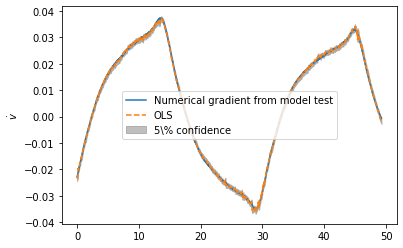

In [228]:
X = diff_eq_Y.calculate_features(data=df, simplify_names=True)
y = diff_eq_Y.calculate_label(y=df['v1d'])

model_Y = sm.OLS(y,X)
results_Y = model_Y.fit()

show_pred(X=X,y=y,results=results_Y, label=r'$\dot{v}$')

In [229]:
X.head()

,Yrrr,Yuu,Yvvv,Yrdeltadelta,Yvdeltadelta,Yrrdelta,Yvrr,Yuudelta,Yuur,Yuuv,Yvvdelta,Yvvr,Yudelta,Yur,Yuv,Yvrdelta,Yrdot,Ydelta,Yr,Yv
time,,,,,,,,,,,,,,,,,,,,
0.000000,1.367641e-08,0.854890,0.000069,0.000073,0.001250,-9.981191e-07,2.346557e-07,-0.149203,0.002044,0.035077,-0.000294,0.000004,-0.161370,0.002211,0.037938,-0.000017,0.013812,-0.174529,0.002391,0.041031
0.009981,1.803417e-08,0.852351,0.000068,0.000080,0.001242,-1.200231e-06,2.804025e-07,-0.148760,0.002235,0.034754,-0.000290,0.000004,-0.161130,0.002421,0.037644,-0.000019,0.013777,-0.174529,0.002622,0.040774
0.019982,2.305219e-08,0.853282,0.000067,0.000087,0.001236,-1.413651e-06,3.287092e-07,-0.148923,0.002428,0.034628,-0.000287,0.000005,-0.161218,0.002629,0.037487,-0.000020,0.013738,-0.174529,0.002846,0.040582
0.029986,2.854261e-08,0.853965,0.000066,0.000093,0.001228,-1.630034e-06,3.766710e-07,-0.149042,0.002610,0.034441,-0.000284,0.000005,-0.161283,0.002824,0.037269,-0.000022,0.013704,-0.174529,0.003056,0.040330
0.039989,3.459135e-08,0.851172,0.000065,0.000099,0.001224,-1.852874e-06,4.265862e-07,-0.148554,0.002773,0.034202,-0.000282,0.000005,-0.161019,0.003006,0.037071,-0.000023,0.013662,-0.174529,0.003258,0.040182


## X

In [230]:
X_eq = eq.X_eq.copy()
X_eq = X_eq.subs([
    #(eq.p.Xudot,1),  # Removing added mass
    #(eq.p.Xvdot,0),  # Removing added mass
    #(eq.p.Xrdot,0),  # Removing added mass
    (x_G,0),
    #(m,0),  # mass
    
])  

solution = sp.solve(X_eq,u.diff())[0]
solution = solution*(m-eq.p.Xudot)
solution = solution - m*r*v
X_eq = sp.Eq(u.diff(), solution)  # Putting r1d on the LHS

In [231]:
Math(vlatex(X_eq))

<IPython.core.display.Math object>

In [232]:
diff_eq_X = regression.DiffEqToMatrix(ode=X_eq, label=u.diff(), base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    u1d   R-squared (uncentered):                   0.794
Model:                            OLS   Adj. R-squared (uncentered):              0.794
Method:                 Least Squares   F-statistic:                              1186.
Date:                Wed, 07 Jul 2021   Prob (F-statistic):                        0.00
Time:                        14:37:58   Log-Likelihood:                          29187.
No. Observations:                4927   AIC:                                 -5.834e+04
Df Residuals:                    4911   BIC:                                 -5.824e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Xdeltadelta      2.3281      0.708      3.290      0.001       0.941       3.715
Xrr           -140.2522     67.611     -2.074      0.038    -272.800      -7.705
Xuu             -1.8589      0.176    -10.577      0.000      -2.203      -1.514
Xuuu             0.9669      0.093     10.343      0.000       0.784       1.150
Xvv            -20.0364      4.302     -4.658      0.000     -28.470     -11.603
Xudeltadelta    -2.5985      0.794     -3.274      0.001      -4.154      -1.043
Xurr           158.5667     75.688      2.095      0.036      10.185     306.948
Xuvv            22.7018      4.812      4.718      0.000      13.269      32.135
Xrdelta         11.2576     13.570      0.830      0.407     -15.346      37.861
Xvdelta          4.0180      3.438      1.169      0.243      -2.722      10.758
Xvr            -67.5308     33.392     -2.022      0.043    -132.994      -2.068
Xurdelta       -11.8511     15.218     -0.779      0.436     -41.685      17.983
Xvrdelta        -0.2938      0.042     -6.933      0.000      -0.377      -0.211
Xuvdelta        -4.2206      3.857     -1.094      0.274     -11.782       3.341
Xuvr            77.7532     37.396      2.079      0.038       4.440     151.067
Xu               0.8929      0.083     10.785      0.000       0.731       1.055
==============================================================================
Omnibus:                      791.787   Durbin-Watson:                   0.172
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3068.311
Skew:                           0.760   Prob(JB):                         0.00
Kurtosis:                       6.555   Cond. No.                     1.77e+07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 3.18e-11. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

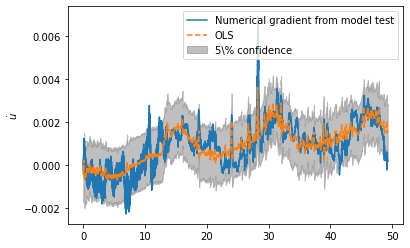

In [233]:
X = diff_eq_X.calculate_features(data=df)
y = diff_eq_X.calculate_label(y=df['u1d'])

model_X = sm.OLS(y,X)
results_X = model_X.fit()

show_pred(X=X,y=y,results=results_X, label=r'$\dot{u}$')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    u1d   R-squared (uncentered):                   0.791
Model:                            OLS   Adj. R-squared (uncentered):              0.790
Method:                 Least Squares   F-statistic:                              1689.
Date:                Wed, 07 Jul 2021   Prob (F-statistic):                        0.00
Time:                        14:40:33   Log-Likelihood:                          29145.
No. Observations:                4927   AIC:                                 -5.827e+04
Df Residuals:                    4916   BIC:                                 -5.820e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Xdeltadelta      2.1341      0.180     11.885      0.000       1.782       2.486
Xrr           -136.7908     14.935     -9.159      0.000    -166.069    -107.512
Xuu             -1.8596      0.162    -11.456      0.000      -2.178      -1.541
Xuuu             0.9934      0.087     11.415      0.000       0.823       1.164
Xvv            -19.8042      1.967    -10.066      0.000     -23.661     -15.947
Xudeltadelta    -2.4015      0.201    -11.926      0.000      -2.796      -2.007
Xurr           153.4085     16.639      9.220      0.000     120.789     186.028
Xuvv            22.2564      2.191     10.159      0.000      17.961      26.551
Xvr            -81.0568      8.723     -9.293      0.000     -98.157     -63.956
Xuvr            91.2880      9.721      9.391      0.000      72.230     110.346
Xu               0.8707      0.076     11.492      0.000       0.722       1.019
==============================================================================
Omnibus:                      987.072   Durbin-Watson:                   0.170
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4850.874
Skew:                           0.880   Prob(JB):                         0.00
Kurtosis:                       7.531   Cond. No.                     3.96e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.96e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

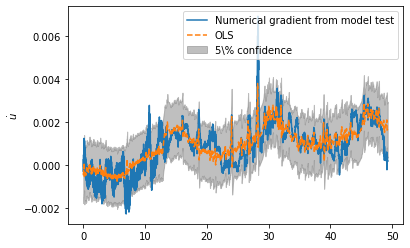

In [243]:
results_summary_X = regression.results_summary_to_dataframe(results_X)
confidence = 0.01
mask = results_summary_X['$P_{value}$'] < confidence
results_summary_X.loc[mask]

good_columns = results_summary_X.loc[mask].index



X_good=X[good_columns]
model_X = sm.OLS(y,X_good)
results_X = model_X.fit()
show_pred(X=X_good,y=y,results=results_X, label=r'$\dot{u}$')
results_summary_X = regression.results_summary_to_dataframe(results_X)

In [235]:

results_summary_Y = regression.results_summary_to_dataframe(results_Y)
results_summary_N = regression.results_summary_to_dataframe(results_N)

## Simulation

In [236]:
eqs = [diff_eq_X.acceleration_equation, diff_eq_Y.acceleration_equation, diff_eq_N.acceleration_equation]
solution = sp.solve(eqs, u.diff(), v.diff(), r.diff(), dict=True)

## Decouple the equations:
u1d_eq = sp.Eq(u.diff(), solution[0][u.diff()]) 
v1d_eq = sp.Eq(v.diff(), solution[0][v.diff()]) 
r1d_eq = sp.Eq(r.diff(), solution[0][r.diff()]) 

## Lambdify:
subs = {value:key for key,value in eq.p.items()}
u1d_lambda = lambdify(u1d_eq.subs(subs).rhs)
v1d_lambda = lambdify(v1d_eq.subs(subs).rhs)
r1d_lambda = lambdify(r1d_eq.subs(subs).rhs)

In [237]:
display(Math(vlatex(u1d_eq)))
display(Math(vlatex(v1d_eq)))
display(Math(vlatex(r1d_eq)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [250]:
from scipy.spatial.transform import Rotation as R

def step(t, states, parameters, df_control, meta_data):
    
    u,v,r,x0,y0,psi = states

    states_dict = {
        
        'u':u,
        'v':v,
        'r':r,
        
        'x0':x0,
        'y0':y0,
        'psi':psi,
        
        }
        
    inputs = dict(parameters)
    inputs.update(states_dict)
    
    index = np.argmin(np.array(np.abs(df_control.index - t)))
    control = dict(df_control.iloc[index])
    #print(f't:{t}, i:{index}')
    inputs.update(control)
    
    inputs['U'] = np.sqrt(u**2 + v**2)  #Instantanious velocity
    
    if not 'u1d' in control:
        #u1d = run(function=u1d_lambda, inputs=inputs) + r*v
        u1d = run(function=u1d_lambda, inputs=inputs)
    else:
        u1d = control['u1d']
    
    mass = meta_data['mass']
    #v1d = run(function=v1d_lambda, inputs=inputs) - u*r
    v1d = run(function=v1d_lambda, inputs=inputs)
    
    r1d = run(function=r1d_lambda, inputs=inputs)
    
    
    rotation = R.from_euler('z', psi, degrees=False)
    w = 0
    velocities = rotation.apply([u,v,w])
    x01d = velocities[0]
    y01d = velocities[1]
    psi1d = r    

    dstates = [
        u1d,
        v1d,
        r1d,
        x01d,
        y01d,
        psi1d,
    ]    
    
    #print(t)
    
    return dstates



In [251]:
parameters = dict(results_summary_X['coeff'])  # Fix (-)
parameters.update(dict(results_summary_Y['coeff']))   # Fix (-)
parameters.update(dict(results_summary_N['coeff']))

states = ['u','v','r','x0','y0','psi']
states0 = [float(df[key].iloc[0]) for key in states]
#df_control = df[['delta','u1d','u']]
df_control = df[['delta']].copy()
#df_control['delta']+=np.deg2rad(0.5)

In [252]:
t_ = 10
index = np.argmin(np.array(np.abs(df_control.index - t_)))
df_control.iloc[index]

delta   -0.174529
Name: 9.999977999999999, dtype: float64

In [253]:
(np.diff(df_control.index) > 0).all()

True

In [255]:
## Simulate:
df_ = df.copy()
t = np.array(df_.index)
t_span = [t[0],t[-1]]
parameters['Xvdelta']=0
parameters['Xurdelta']=0
parameters['Xuvdelta']=0
parameters['Xrdelta']=0
parameters['Nuu']=0
parameters['Ndeltadeltadelta']=0
parameters['Xvrdelta']=0
solution = solve_ivp(fun=step, t_span=t_span, y0=states0, t_eval=t, args=(parameters, df_control, meta_data), method='RK45')

In [256]:
df_result = pd.DataFrame(data=solution.y.T, columns=states)
df_result.index=t[0:len(df_result)]

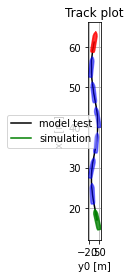

In [257]:
fig,ax=plt.subplots()
#fig.set_size_inches(15,15)
track_plot(df=df_, lpp=meta_data['lpp'], beam=meta_data['beam'], ax=ax, color='k', label='model test');
track_plot(df=df_result, lpp=meta_data['lpp'], beam=meta_data['beam'], ax=ax, color='g', label='simulation');
ax.legend()

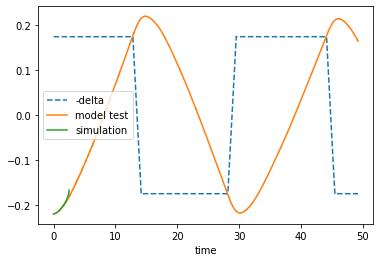

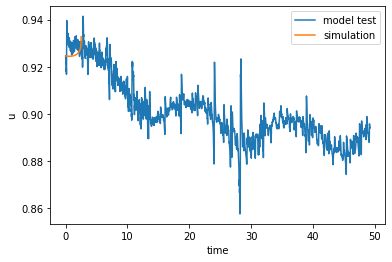

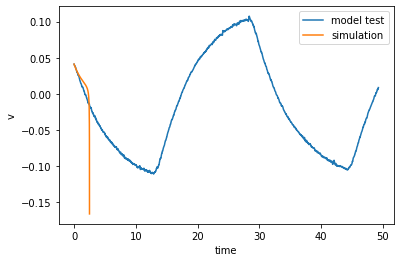

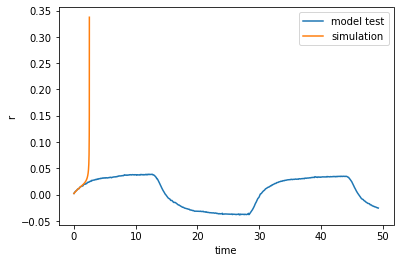

In [258]:
fig,ax=plt.subplots()
df_['-delta'] = -df_['delta']
df_.plot(y='-delta', style='--', ax=ax)
df_.plot(y='psi', ax=ax, label='model test')
df_result.plot(y='psi', ax=ax, label='simulation')
ax.legend()


for key in ['u','v','r']:
    
    fig,ax=plt.subplots()
    df_.plot(y=key, ax=ax, label='model test')
    df_result.plot(y=key, ax=ax, label='simulation')
    ax.set_ylabel(key)
